In [ ]:
!curl -L https://huggingface.co/datasets/metalwhale/stock_data/resolve/main/us_data.zip -o ./data/raw/us_data.zip
!unzip ./data/raw/us_data.zip -d ./data/us_data

In [1]:
import glob
import os
from pathlib import Path

import pandas as pd

# Dow components (as of August 31, 2020). See: https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average
DOW_COMPANIES = [
    "AXP", "AMGN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DIS", "DOW",
    "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "MCD", "MMM", "MRK",
    "MSFT", "NKE", "PG", "CRM", "TRV", "UNH", "VZ", "V", "WBA", "WMT",
]


def read_data(pattern: str) -> pd.DataFrame:
    df = None
    for company_file_path in glob.glob(pattern):
        symbol = Path(company_file_path).stem
        if symbol not in DOW_COMPANIES:
            os.remove(company_file_path)
            continue
        if symbol in ["CRM", "DOW", "V"]:  # These companies don't have much data
            continue
        company_df = pd.read_csv(company_file_path)\
            .filter(items=["date", "close", "volume"])\
            .rename(columns={"close": f"{symbol}_close", "volume": f"{symbol}_volume"})
        company_df = company_df.set_index(["date"])
        company_df.index = pd.to_datetime(company_df.index, utc=True, format="mixed").strftime("%Y-%m-%d")
        if df is None:
            df = company_df
        else:
            df = df.join(company_df, how="inner")
    df.index = pd.to_datetime(df.index)
    df.columns = pd.MultiIndex.from_tuples(
        [tuple(c.split("_")) for c in df.columns.values],
        names=["asset", "channels"],
    )
    return df


df = read_data("./data/us_data/*.csv")
n_assets = len(df.columns.levels[0])
n_channels = len(df.columns.levels[1])

In [2]:
from typing import Tuple

import torch
from deepdow.data import InRAMDataset, RigidDataLoader, Noise, prepare_standard_scaler
from deepdow.utils import raw_to_Xy


def generate_dataloaders(
        df: pd.DataFrame, lookback: int, gap: int, horizon: int,
) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    X, timestamps, y, asset_names, _indicators = raw_to_Xy(df, lookback=lookback, gap=gap, freq="B", horizon=horizon)
    n_samples = X.shape[0]
    test_ratio = 0.1
    indices_test = list(range(0, n_samples, int(1 / test_ratio)))
    indices_train = [i for i in list(range(n_samples)) if i not in indices_test]
    means, stds = prepare_standard_scaler(X, indices=indices_train)
    dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names, transform=Noise())
    batch_size = 32
    dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=batch_size)
    dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=batch_size)
    return dataloader_train, dataloader_test


lookback, gap, horizon = 20, 2, 4
torch.manual_seed(1)
dataloader_train, dataloader_test = generate_dataloaders(df, lookback, gap, horizon)

In [3]:
from deepdow.nn import KeynesNet, LinearNet


def build_network(n_channels: int, n_assets: int, lookback: int) -> torch.nn.Module:
    # network = LinearNet(n_channels, lookback, n_assets)
    network = KeynesNet(n_channels)
    network.train()
    return network


network = build_network(n_channels, n_assets, lookback)
print(network)

KeynesNet(
  (transform_layer): RNN(
    (cell): LSTM(2, 32)
  )
  (norm_layer_1): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (norm_layer_2): GroupNorm(4, 32, eps=1e-05, affine=True)
  (time_collapse_layer): AverageCollapse()
  (channel_collapse_layer): AverageCollapse()
  (portfolio_opt_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


In [4]:
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.experiments import Run
from deepdow.losses import MaximumDrawdown, MeanReturns, SharpeRatio


def train_network(network: torch.nn.Module, dataloader_train: torch.utils.data.DataLoader, dataloader_test: torch.utils.data.DataLoader):
    run = Run(
        network,
        MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio(),
        dataloader_train,
        val_dataloaders={"test": dataloader_test},
        optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
        callbacks=[EarlyStoppingCallback(metric_name="loss", dataloader_name="test", patience=25)],
    )
    run.launch(1000)


train_network(network, dataloader_train, dataloader_test)

Epoch 166: 100%|██████████| 177/177 [00:09<00:00, 18.01it/s, loss=-0.23947, test_loss=-0.18281]


Training interrupted
Training stopped early because there was no improvement in test_loss for 25 epochs


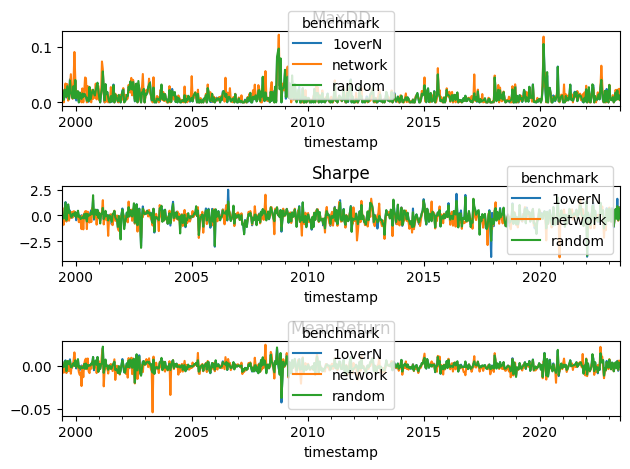

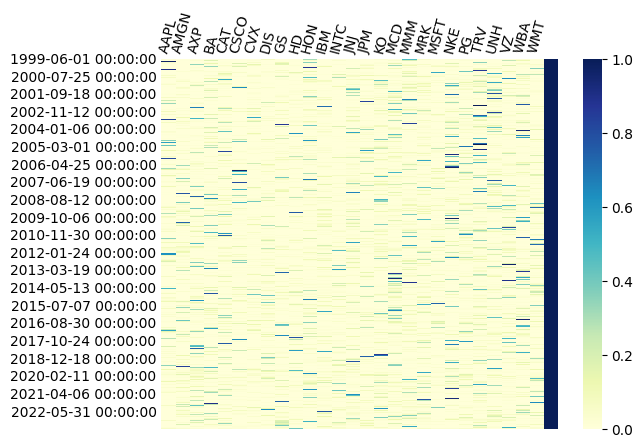

In [5]:
import matplotlib.pyplot as plt
from deepdow.benchmarks import OneOverN, Random
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap


def eval_network(network: torch.nn.Module, dataloader_test: torch.utils.data.DataLoader):
    network = network.eval()
    benchmarks = {
        "1overN": OneOverN(),
        "random": Random(),
        "network": network,
    }
    metrics = {
        "MaxDD": MaximumDrawdown(),
        "Sharpe": SharpeRatio(),
        "MeanReturn": MeanReturns(),
    }
    metrics_table = generate_metrics_table(benchmarks, dataloader_test, metrics)
    plot_metrics(metrics_table)
    plt.show()
    weight_table = generate_weights_table(network, dataloader_test)
    plot_weight_heatmap(weight_table, add_sum_column=True, time_format=None, time_skips=30)
    plt.show()


eval_network(network, dataloader_test)